# Preparation

In [1]:
import functions_and_variables as fs
import os

In [2]:
# emotions_data = fs.read_file(fs.data_path + "complete.txt", ";")
emotions_data = fs.read_file(fs.train_file, ";")
# emotions_data += fs.read_file(fs.test_file, ";")
# emotions_data += fs.read_file(fs.val_file, ";")

categories = list(set([emotion for sentence, emotion in emotions_data]))
categories = sorted(categories, key=lambda x: x.lower())

In [3]:
dataframe_sizes = dict.fromkeys(categories, 0)
dataframe_categories = dict.fromkeys(categories, "")

for categorie in categories:
    try:
        os.remove(fs.corpus + categorie + ".txt")
    except:
        next

for sentence, emotion in emotions_data:
    fs.write_to_file(fs.corpus + emotion + ".txt", sentence + ". ", False)
    dataframe_sizes[emotion] += 1 
    dataframe_categories[emotion] += sentence + ". "

# Exc 1 

In [4]:
from matplotlib import pyplot as plt 

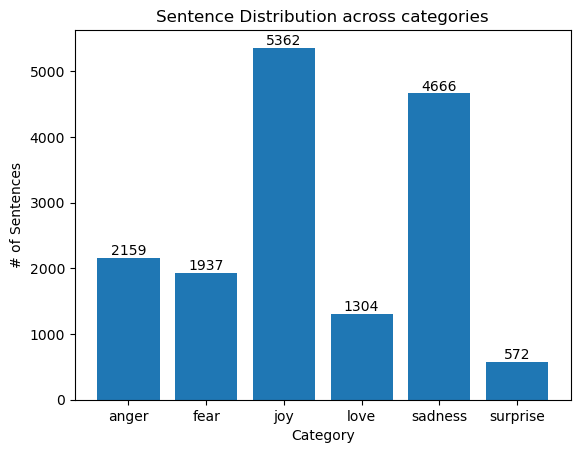

In [5]:
# inspired from https://www.geeksforgeeks.org/adding-labels-to-histogram-bars-in-matplotlib/
# hist was changed to bar and labels were set accordingly

fig, ax = plt.subplots(1, 1) 
ax.bar(dataframe_sizes.keys(), dataframe_sizes.values()) 
  
ax.set_title("Sentence Distribution across categories") 
  
ax.set_xlabel('Category') 
ax.set_ylabel('# of Sentences') 
  
rects = ax.patches 
  
for rect, label in zip(rects, dataframe_sizes.values()): 
    height = rect.get_height() 
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label, 
            ha='center', va='bottom')

# Show plot 
plt.show() 

#### Comment:
The data is distributed super unbalanced. The training data should therefore be balanced before it is used to train the model.

# Exc 2

Inspired from
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [6]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
from nltk import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords

import pandas as pd

from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [7]:
# Perform Stemming and remove Stopwords
def preprocess(sentences: list):
    cleaned = []
    
    for sentence in sentences: 
        stop_words = list(set(stopwords.words('english')))
        stop_words.extend(['im', 'ive','dont','cant'])
        stemmer = PorterStemmer()
    
        word_tokens = word_tokenize(sentence)
        cleaned.extend([stemmer.stem(w) for w in word_tokens if not w.lower() in stop_words])
    
    return cleaned

# Returns the words of a sentence
def sent_to_words(sentences: list):
        return [word_tokenize(sentence) for sentence in sentences]

In [8]:
def perform_lda(category: str, data: list, shoud_preprocess: bool, num_topis: int, num_words: int):
    print(category + ":")

    data_words = []

    if not shoud_preprocess:
        data_words = list(sent_to_words(data))

    else:
        data_words.append(preprocess(data))
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)
    
    # Create Corpus
    texts = data_words
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,
                                           num_topics=num_topics)

    # Print the Keyword with the specified number of words
    keywords = lda_model.print_topics(num_words=num_words)
    pprint(keywords)
    file_path = fs.result_path + category + '_lda_ana.txt'
    fs.write_to_file(file_path, 
                     str(keywords), True)
    print('File for "' + category +'" successfully created at: ' + file_path + '\n')
    return id2word, corpus, lda_model

In [9]:
num_topics = 3
num_words = 4
lda_dict = dict.fromkeys(categories, [])
pyLDAvis.enable_notebook()

index = 0
for category in categories:    
    # Perform LDA for the current topic
    lda_dict[category] = perform_lda(category, 
                                             dataframe_categories[category].split('. '), False, 
                                             num_topics, num_words)

anger:
[(0, '0.069*"i" + 0.027*"feel" + 0.021*"and" + 0.017*"feeling"'),
 (1, '0.086*"i" + 0.035*"and" + 0.030*"feel" + 0.027*"to"'),
 (2, '0.067*"i" + 0.036*"feel" + 0.029*"the" + 0.027*"to"')]
File for "anger" successfully created at: ./results/anger_lda_ana.txt

fear:
[(0, '0.049*"i" + 0.031*"a" + 0.031*"and" + 0.022*"feel"'),
 (1, '0.091*"i" + 0.036*"feel" + 0.033*"to" + 0.023*"and"'),
 (2, '0.066*"i" + 0.033*"the" + 0.031*"and" + 0.024*"feel"')]
File for "fear" successfully created at: ./results/fear_lda_ana.txt

joy:
[(0, '0.068*"i" + 0.034*"the" + 0.034*"to" + 0.028*"feel"'),
 (1, '0.089*"i" + 0.052*"feel" + 0.026*"the" + 0.024*"and"'),
 (2, '0.072*"i" + 0.041*"and" + 0.031*"to" + 0.028*"feel"')]
File for "joy" successfully created at: ./results/joy_lda_ana.txt

love:
[(0, '0.072*"i" + 0.034*"feel" + 0.032*"to" + 0.024*"and"'),
 (1, '0.048*"i" + 0.037*"and" + 0.024*"to" + 0.021*"the"'),
 (2, '0.076*"i" + 0.034*"feel" + 0.030*"and" + 0.030*"the"')]
File for "love" successfully cr

# Exc 3

Inspired from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [10]:
def visualize_lda(category: str, id2word, corpus, lda_model, num_topics: int):
    # Create the directory if it doesn't exist
    os.makedirs(fs.result_path, exist_ok=True)
    
    filename = fs.result_path + category + '_ldavis_prepared_'+ str(num_topics)
    LDAvis_data_filepath = os.path.join(filename)
    
    ### this is a bit time consuming - make the if statement True
    ### if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, n_jobs=1)
        
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
    
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    
    html_filename = filename + '.html'
    pyLDAvis.save_html(LDAvis_prepared, html_filename)
    print('File for "' + category + '" successfully created at: ' + html_filename + '\n')
    return LDAvis_prepared, html_filename

In [11]:
for category in categories:    
    # Create visualisation
    prepared_data, html_filename = visualize_lda(category, lda_dict[category][0], lda_dict[category][1], 
                                                 lda_dict[category][2], num_topics)
    
    # Display the visualization directly in the notebook
    #display(pyLDAvis.display(prepared_data))
    
    # Open the HTML files in a web browser (if running on windows: replace "open " with "start ")
    #os.system("open " + html_filename)

File for "anger" successfully created at: ./results/anger_ldavis_prepared_3.html

File for "fear" successfully created at: ./results/fear_ldavis_prepared_3.html

File for "joy" successfully created at: ./results/joy_ldavis_prepared_3.html

File for "love" successfully created at: ./results/love_ldavis_prepared_3.html

File for "sadness" successfully created at: ./results/sadness_ldavis_prepared_3.html

File for "surprise" successfully created at: ./results/surprise_ldavis_prepared_3.html

